# Libraries


In [31]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.stats import kstest, ttest_ind, mannwhitneyu

# Load preprocessed Images

In [3]:
# Load preprocessed (CLAHE + resized) images from processed folders

def load_image_paths(directory):
    """
    Return a list of image file paths from a directory.
    """
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Directories for processed images
normal_processed_dir = r"C:\Users\User\Documents\UdeA\Señales II\Proyecto Final\Pneumonia-Detection\data\processed\normal"
pneumonia_processed_dir = r"C:\Users\User\Documents\UdeA\Señales II\Proyecto Final\Pneumonia-Detection\data\processed\pneumonia"

# Load image paths
normal_clahe_paths = load_image_paths(normal_processed_dir)
pneumonia_clahe_paths = load_image_paths(pneumonia_processed_dir)

print(f"Loaded {len(normal_clahe_paths)} normal images and {len(pneumonia_clahe_paths)} pneumonia images.")

Loaded 250 normal images and 250 pneumonia images.


# HOG and LBP for extract features

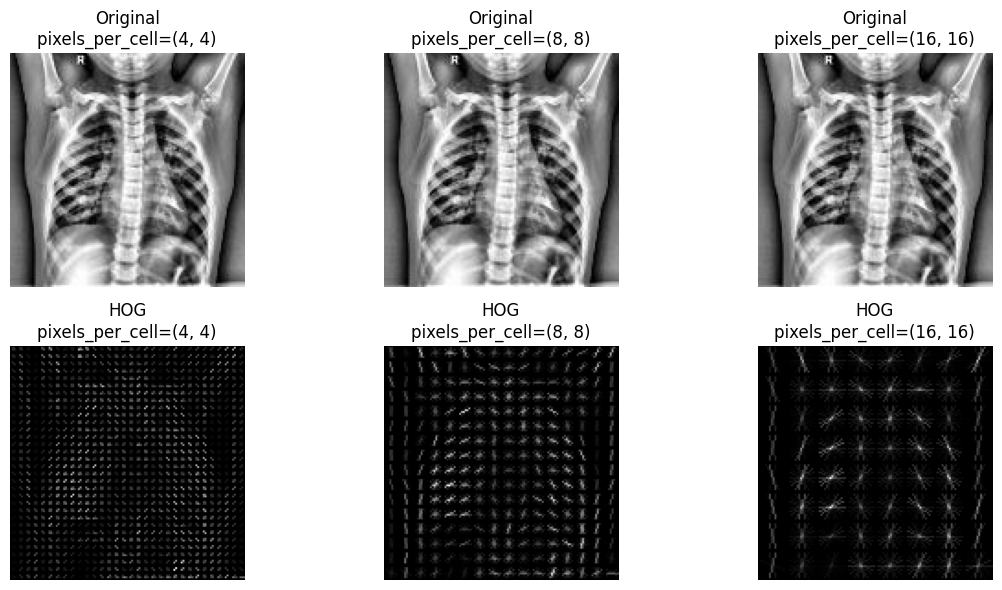

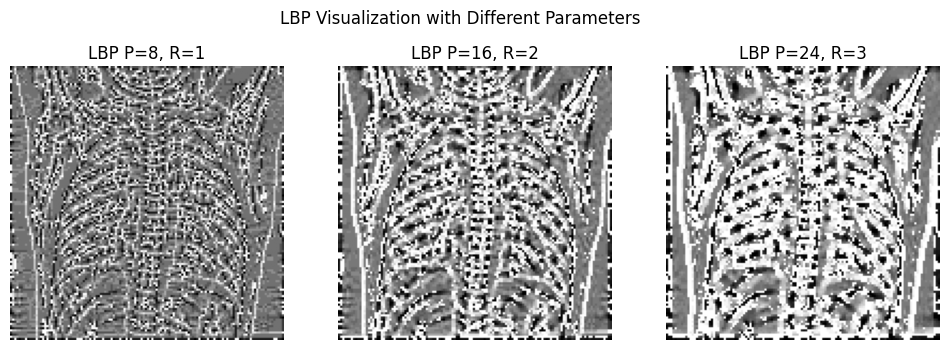

In [8]:
def extract_hog_features(image_paths, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=False):
    """
    Extract HOG (Histogram of Oriented Gradients) features from a list of image file paths.

    Args:
        image_paths (list): List of image file paths.
        pixels_per_cell (tuple): Size (in pixels) of a cell. Typical values: (8,8), (16,16).
        cells_per_block (tuple): Number of cells in each block. Typical values: (2,2), (3,3).
        visualize (bool): If True, also returns the HOG images for visualization.

    Returns:
        np.ndarray: Array of HOG feature vectors.
        (optional) list: List of HOG images (if visualize=True).
    """
    features = []
    hog_images = []
    for path in image_paths:
        img = np.array(Image.open(path).convert("L")) / 255.0
        hog_feat, hog_img = hog(
            img,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            visualize=True,
            feature_vector=True
        )
        features.append(hog_feat)
        if visualize:
            hog_images.append(hog_img)
    if visualize:
        return np.array(features), hog_images
    return np.array(features)

def extract_lbp_features(image_paths, P=8, R=1, method="uniform"):
    """
    Extract LBP (Local Binary Pattern) histograms from a list of image file paths.

    Args:
        image_paths (list): List of image file paths.
        P (int): Number of circularly symmetric neighbour set points (e.g., 8, 16, 24).
        R (float): Radius of circle (e.g., 1, 2, 3).
        method (str): LBP method, e.g., "uniform", "default", "ror", "var".

    Returns:
        np.ndarray: Array of normalized LBP histograms.
    """
    features = []
    for path in image_paths:
        img = np.array(Image.open(path).convert("L")) / 255.0
        lbp = local_binary_pattern(img, P, R, method=method)
        # Normalized histogram of LBP patterns
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        features.append(hist)
    return np.array(features)

sample_idx = 0 # index to visualize another image

# Visualización HOG con diferentes tamaños de celda
cell_sizes = [(4, 4), (8, 8), (16, 16)]
plt.figure(figsize=(12, 6))

for i, cell in enumerate(cell_sizes):
    hog_feat, hog_img = hog(
        img,
        pixels_per_cell=cell,
        cells_per_block=(2, 2),
        visualize=True,
        feature_vector=True
    )
    plt.subplot(2, 3, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"Original\npixels_per_cell={cell}")
    plt.axis("off")
    plt.subplot(2, 3, i+4)
    plt.imshow(hog_img, cmap="gray")
    plt.title(f"HOG\npixels_per_cell={cell}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# LBP visualization with different parameters
lbp_params = [
    {"P": 8, "R": 1, "method": "uniform"},
    {"P": 16, "R": 2, "method": "uniform"},
    {"P": 24, "R": 3, "method": "uniform"}
]

plt.figure(figsize=(12, 4))
for i, params in enumerate(lbp_params):
    lbp = local_binary_pattern(img, params["P"], params["R"], method=params["method"])
    plt.subplot(1, len(lbp_params), i+1)
    plt.imshow(lbp, cmap="gray")
    plt.title(f"LBP P={params['P']}, R={params['R']}")
    plt.axis("off")
plt.suptitle("LBP Visualization with Different Parameters")
plt.show()

# Extract features for all images (default parameters)
# normal_hog = extract_hog_features(normal_clahe_paths)
#pneumonia_hog = extract_hog_features(pneumonia_clahe_paths)
#normal_lbp = extract_lbp_features(normal_clahe_paths)
#pneumonia_lbp = extract_lbp_features(pneumonia_clahe_paths)



## HOG:
- pixels_per_cell: Size of the cell in pixels. Smaller cells capture finer details, larger cells capture more global structure.
- cells_per_block: Number of cells in each block for normalization. Larger blocks provide more context for normalization.

## LBP:
- P: Number of sampling points (neighbors) on the circle.
- R: Radius of the circle.
- method: LBP variant. "uniform" is most common for texture analysis.

## How much features we have?

- LPB: Número de bins = P + 2 = 10<br>
  Total features = 10<br>
  
- HOG: n_blocks_row = (128 // 4) - 2 + 1 = 32 - 2 + 1 = 31<br>
  n_blocks_col = (128 // 4) - 2 + 1 = 31<br>
  n_blocks_total = 31 × 31 = 961<br>
  features_per_block = 2 × 2 × 9 = 36<br>
  Total features = 961 × 36 = 34,596

In [7]:
# HOG: pixels_per_cell=(4, 4), cells_per_block=(2, 2)
normal_hog = extract_hog_features(normal_clahe_paths, pixels_per_cell=(4, 4), cells_per_block=(2, 2))
pneumonia_hog = extract_hog_features(pneumonia_clahe_paths, pixels_per_cell=(4, 4), cells_per_block=(2, 2))

print("HOG normal shape:", normal_hog.shape) 
print("HOG pneumonia shape:", pneumonia_hog.shape)

# LBP: P=8, R=1, method="uniform"
normal_lbp = extract_lbp_features(normal_clahe_paths, P=8, R=1, method="uniform")
pneumonia_lbp = extract_lbp_features(pneumonia_clahe_paths, P=8, R=1, method="uniform")

print("LBP normal shape:", normal_lbp.shape)   
print("LBP pneumonia shape:", pneumonia_lbp.shape)

HOG normal shape: (250, 34596)
HOG pneumonia shape: (250, 34596)
LBP normal shape: (250, 10)
LBP pneumonia shape: (250, 10)


# Unify all on a Dataframe

In [12]:
X_normal = np.hstack([normal_hog, normal_lbp])
X_pneumonia = np.hstack([pneumonia_hog, pneumonia_lbp])

y_normal = np.zeros(X_normal.shape[0], dtype=int)
y_pneumonia = np.ones(X_pneumonia.shape[0], dtype=int)

X = np.vstack([X_normal, X_pneumonia])
y = np.concatenate([y_normal, y_pneumonia])

df = pd.DataFrame(X)
df['label'] = y

print(df.shape) 
df.head()

(500, 34607)


,0,1,2,3,4,5,6,7,8,9,...,34597,34598,34599,34600,34601,34602,34603,34604,34605,label
0,0.304963,0.00000,0.0,0.0,0.068710,0.000000,0.213733,0.184476,0.304963,0.304963,...,0.069275,0.056824,0.123108,0.295410,0.156311,0.060852,0.061890,0.049377,0.086243,0
1,0.349867,0.06406,0.0,0.0,0.039186,0.000000,0.000000,0.000000,0.148155,0.349867,...,0.062683,0.058044,0.125122,0.258911,0.153748,0.065857,0.055115,0.082581,0.091797,0
2,0.271176,0.00000,0.0,0.0,0.013559,0.011181,0.000000,0.365818,0.256427,0.365818,...,0.063843,0.057251,0.119080,0.294495,0.155457,0.061584,0.055237,0.076294,0.082153,0
3,0.210184,0.00000,0.0,0.0,0.105092,0.000000,0.000000,0.319426,0.255849,0.243213,...,0.064026,0.058289,0.128845,0.298096,0.160950,0.064392,0.056824,0.048096,0.082764,0
4,0.183156,0.00000,0.0,0.0,0.226238,0.309743,0.309743,0.270943,0.079837,0.078495,...,0.064758,0.053650,0.118652,0.258118,0.146362,0.065186,0.058594,0.105286,0.086853,0


In [13]:
df.tail()

,0,1,2,3,4,5,6,7,8,9,...,34597,34598,34599,34600,34601,34602,34603,34604,34605,label
495,0.251504,0.000000,0.000000,0.000000,0.050981,0.000000,0.000000,0.000000,0.463151,0.463151,...,0.061523,0.056946,0.125000,0.288940,0.158447,0.064514,0.054749,0.068115,0.082642,1
496,0.168254,0.053532,0.093271,0.078451,0.170153,0.018365,0.000000,0.081767,0.000000,0.344305,...,0.071594,0.057190,0.120544,0.269104,0.156860,0.072327,0.061768,0.059692,0.090393,1
497,0.089437,0.000000,0.000000,0.000000,0.113659,0.082528,0.199306,0.055305,0.109194,0.423061,...,0.059387,0.057434,0.138000,0.284058,0.170166,0.069031,0.054504,0.053528,0.078552,1
498,0.043720,0.093304,0.174670,0.107038,0.301146,0.000000,0.000000,0.000000,0.089044,0.301146,...,0.072144,0.060059,0.122253,0.271790,0.149292,0.069885,0.063477,0.052002,0.095947,1
499,0.079298,0.000000,0.158478,0.029634,0.142445,0.000000,0.023281,0.022484,0.000000,0.350013,...,0.071106,0.057068,0.123718,0.273315,0.148560,0.071716,0.064453,0.051758,0.093445,1


C:\Users\User\AppData\Local\Temp\ipykernel_4892\3873642210.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_scaled[df_scaled['label']==0].iloc[:, i], df_scaled[df_scaled['label']==1].iloc[:, i]],
C:\Users\User\AppData\Local\Temp\ipykernel_4892\3873642210.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_scaled[df_scaled['label']==0].iloc[:, i], df_scaled[df_scaled['label']==1].iloc[:, i]],
C:\Users\User\AppData\Local\Temp\ipykernel_4892\3873642210.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_scaled[df_scaled['label']==0].iloc[:, i], df_scaled[df_scaled['la

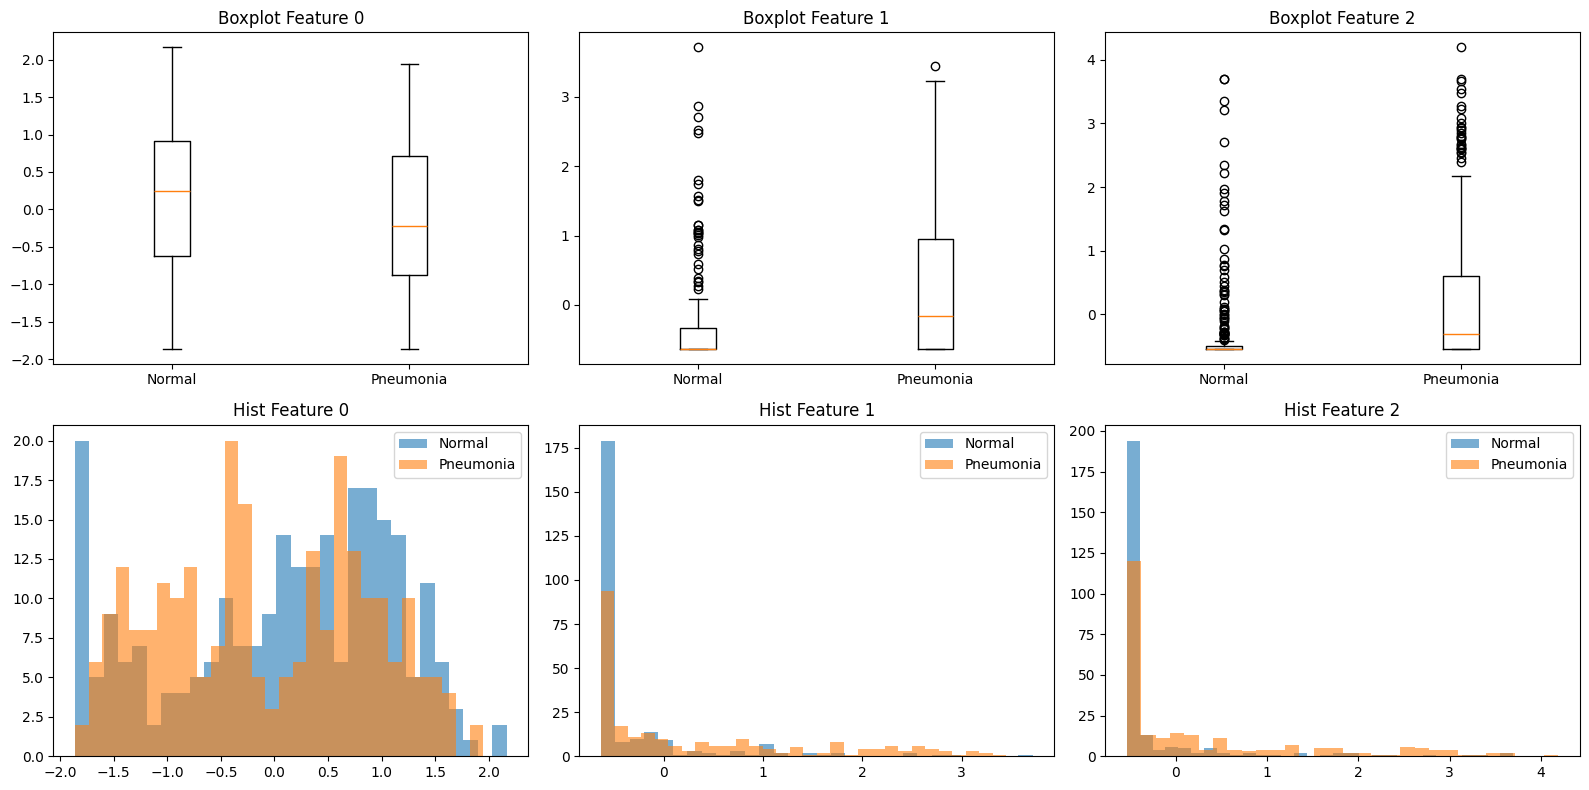

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop('label', axis=1))
df_scaled = pd.DataFrame(X_scaled, columns=df.columns[:-1])
df_scaled['label'] = df['label'].values

plt.figure(figsize=(16, 8))
for i in range(3):
    # Boxplot
    plt.subplot(2, 3, i+1)
    plt.boxplot([df_scaled[df_scaled['label']==0].iloc[:, i], df_scaled[df_scaled['label']==1].iloc[:, i]],
                labels=['Normal', 'Pneumonia'])
    plt.title(f'Boxplot Feature {i}')
    # Histograma
    plt.subplot(2, 3, i+4)
    plt.hist(df_scaled[df_scaled['label']==0].iloc[:, i], bins=30, alpha=0.6, label='Normal')
    plt.hist(df_scaled[df_scaled['label']==1].iloc[:, i], bins=30, alpha=0.6, label='Pneumonia')
    plt.title(f'Hist Feature {i}')
    plt.legend()
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_4892\270675592.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_scaled[df_scaled['label']==0].iloc[:, feature_idx],


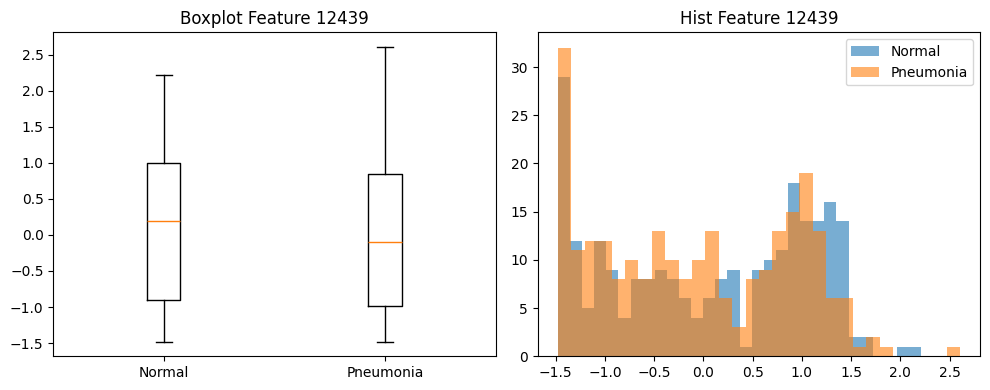

In [30]:
feature_idx = 12439 # index for feature to visualize

plt.figure(figsize=(10, 4))

# Boxplot
plt.subplot(1, 2, 1)
plt.boxplot([df_scaled[df_scaled['label']==0].iloc[:, feature_idx], 
             df_scaled[df_scaled['label']==1].iloc[:, feature_idx]],
            labels=['Normal', 'Pneumonia'])
plt.title(f'Boxplot Feature {feature_idx}')

# Histogram
plt.subplot(1, 2, 2)
plt.hist(df_scaled[df_scaled['label']==0].iloc[:, feature_idx], bins=30, alpha=0.6, label='Normal')
plt.hist(df_scaled[df_scaled['label']==1].iloc[:, feature_idx], bins=30, alpha=0.6, label='Pneumonia')
plt.title(f'Hist Feature {feature_idx}')
plt.legend()

plt.tight_layout()
plt.show()

# Conlusion about features

## Outliers in HOG and LBP Features: What Do They Mean?

When applying HOG (Histogram of Oriented Gradients) and LBP (Local Binary Patterns) to images, it is common to observe outliers in the resulting feature distributions. Here’s what these outliers can represent:

- **Natural Image Variability:** Outliers often reflect real differences in image content, such as strong edges, textures, or anatomical structures that are present in some images but not others.
- **Contrast Between Regions:** Some image regions may be homogeneous (low feature values), while others contain sharp transitions or patterns (high feature values), leading to extreme values in the feature vectors.
- **Pathological or Anatomical Changes:** In medical images, outliers may correspond to abnormal findings (e.g., lesions, consolidations) or anatomical variations, which are precisely the differences you want to capture for classification.
- **Non-Normal Distributions:** HOG and LBP features are often not normally distributed, as they are based on histograms or counts, which can be skewed or have long tails.

**Key Point:**  
Outliers in HOG and LBP features are not necessarily noise or errors. They often contain valuable information about the underlying image content

# Statistics tests

In [29]:
X_normal = df[df['label'] == 0].drop('label', axis=1).values
X_pneumonia = df[df['label'] == 1].drop('label', axis=1).values

normality_results = []
stat_test_results = []

for i in range(X_normal.shape[1]):
    stat_norm, p_norm = kstest(X_normal[:, i], 'norm')
    stat_pneu, p_pneu = kstest(X_pneumonia[:, i], 'norm')
    is_normal = (p_norm > 0.05) and (p_pneu > 0.05)
    normality_results.append(is_normal)
    
    if is_normal:
        stat, p = ttest_ind(X_normal[:, i], X_pneumonia[:, i], equal_var=False)
        test_used = 't-test'
    else:
        stat, p = mannwhitneyu(X_normal[:, i], X_pneumonia[:, i], alternative='two-sided')
        test_used = 'mannwhitneyu'
    stat_test_results.append({'feature': i, 'test': test_used, 'p_value': p})

# print some results
for res in stat_test_results[:5]:
    print(res)

# How much features are normally distributed in both classes
n_normal = sum(normality_results)
print(f"\nCaracterísticas que siguen distribución normal en ambas clases: {n_normal} de {len(normality_results)}")

# wich features are normal
for idx, is_norm in enumerate(normality_results[:10]):  # only first 10
    print(f"Feature {idx}: {'Normal' if is_norm else 'No normal'}")

# How much features do not show significant difference between classes
same_dist_count = sum(res['p_value'] > 0.05 for res in stat_test_results)
print(f"\nCaracterísticas que NO muestran diferencia significativa entre clases (p > 0.05): {same_dist_count} de {len(stat_test_results)}")

# Which features do not show significant difference (show 10 random features)
no_diff_features = [res for res in stat_test_results if res['p_value'] > 0.05]
sampled = random.sample(no_diff_features, min(10, len(no_diff_features)))

print("10 random features with no significant difference between classes:")
for res in sampled:
    print(f"Feature {res['feature']}: No significant difference (p = {res['p_value']:.4f}) using {res['test']}")

{'feature': 0, 'test': 'mannwhitneyu', 'p_value': np.float64(0.05006994034693742)}
{'feature': 1, 'test': 'mannwhitneyu', 'p_value': np.float64(3.5332741386817416e-16)}
{'feature': 2, 'test': 'mannwhitneyu', 'p_value': np.float64(8.245688097553828e-13)}
{'feature': 3, 'test': 'mannwhitneyu', 'p_value': np.float64(1.858366864611127e-05)}
{'feature': 4, 'test': 'mannwhitneyu', 'p_value': np.float64(3.9924683617165825e-05)}

Características que siguen distribución normal en ambas clases: 0 de 34606
Feature 0: No normal
Feature 1: No normal
Feature 2: No normal
Feature 3: No normal
Feature 4: No normal
Feature 5: No normal
Feature 6: No normal
Feature 7: No normal
Feature 8: No normal
Feature 9: No normal

Características que NO muestran diferencia significativa entre clases (p > 0.05): 18244 de 34606
10 random features with no significant difference between classes:
Feature 12439: No significant difference (p = 0.0877) using mannwhitneyu
Feature 27835: No significant difference (p = 0.921

## Feature Selection Based on Statistical Significance

After identifying features that do **not** show a significant difference between classes (p > 0.05), the next step is to consider their impact on model performance.

### What will be done?

- **Feature Removal:**  
  Features that do not significantly differentiate between classes will be considered for removal. This can help reduce dimensionality, noise, and potential overfitting.

- **Model Comparison:**  
  In practice, the ideal approach is to train and evaluate models **with and without** these non-significant features. By comparing the evaluation metrics (such as accuracy, precision, recall, F1-score, ROC-AUC, etc.), we can determine whether removing these features improves, worsens, or does not affect the model's performance.

- **Decision Making:**  
  The final decision on whether to keep or remove these features will be based on the observed impact on model performance, rather than relying solely on statistical tests.

**Summary:**  
Statistical tests are a useful guide for feature selection, but the ultimate criterion should always be the performance of the predictive model on relevant metrics.

# Dimensionality reduction and visualization

PCA reduced shape (95% variance): (500, 448)


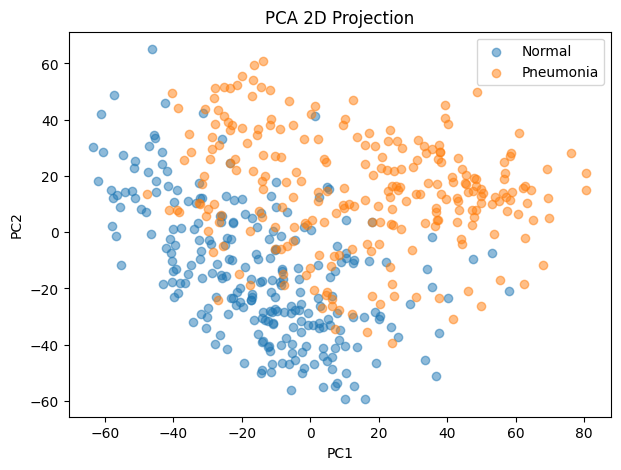

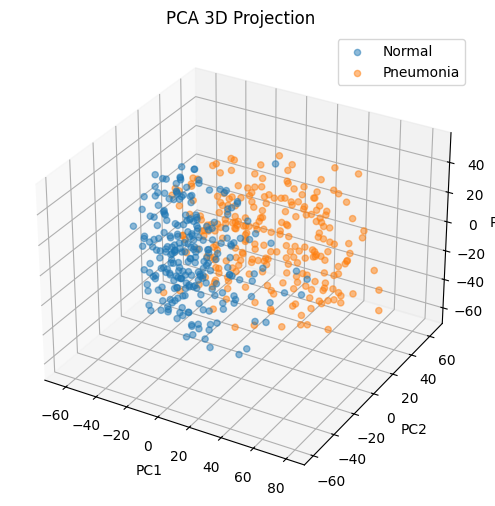

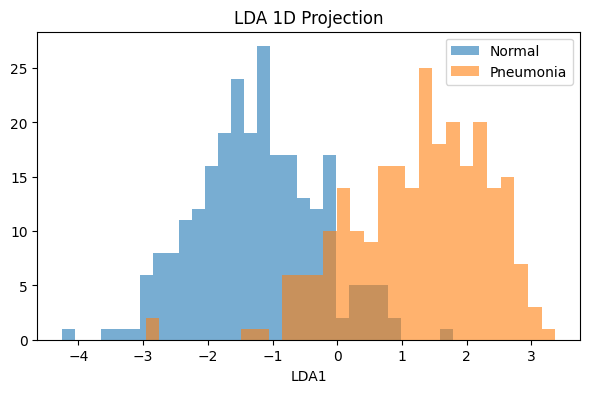

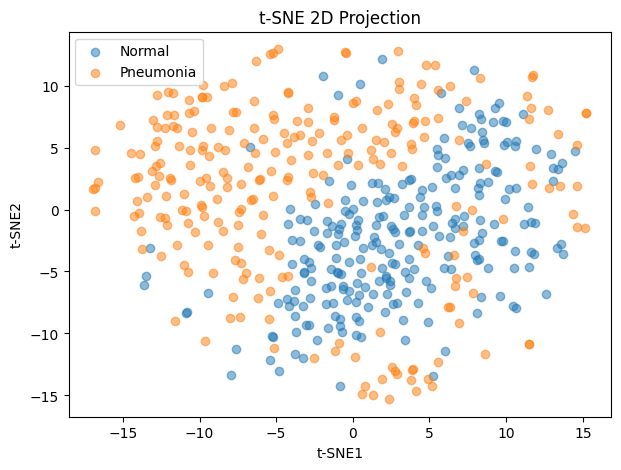

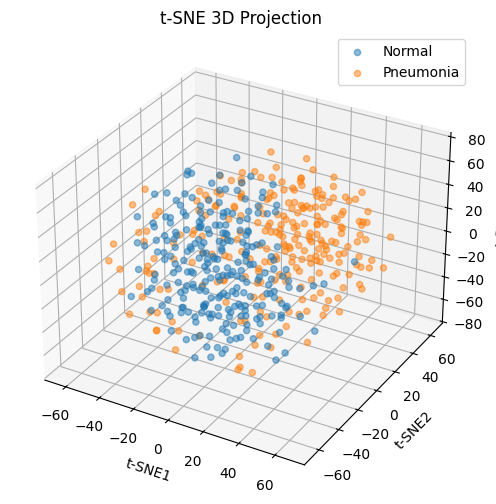

In [32]:
X_features = df_scaled.drop('label', axis=1).values
y_labels = df_scaled['label'].values

# PCA: Fit and transform to retain 95% of variance
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_features)
print(f"PCA reduced shape (95% variance): {X_pca.shape}")

# 2D PCA plot
plt.figure(figsize=(7,5))
plt.scatter(X_pca[y_labels==0, 0], X_pca[y_labels==0, 1], alpha=0.5, label='Normal')
plt.scatter(X_pca[y_labels==1, 0], X_pca[y_labels==1, 1], alpha=0.5, label='Pneumonia')
plt.title('PCA 2D Projection')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

# 3D PCA plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[y_labels==0, 0], X_pca[y_labels==0, 1], X_pca[y_labels==0, 2], alpha=0.5, label='Normal')
ax.scatter(X_pca[y_labels==1, 0], X_pca[y_labels==1, 1], X_pca[y_labels==1, 2], alpha=0.5, label='Pneumonia')
ax.set_title('PCA 3D Projection')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()

# LDA: Only 1 component for 2 classes, but we can plot in 1D and 2D (if more classes, use n_components=2)
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X_features, y_labels)
plt.figure(figsize=(7,4))
plt.hist(X_lda[y_labels==0], bins=30, alpha=0.6, label='Normal')
plt.hist(X_lda[y_labels==1], bins=30, alpha=0.6, label='Pneumonia')
plt.title('LDA 1D Projection')
plt.xlabel('LDA1')
plt.legend()
plt.show()

# For 2D LDA plot (if more than 2 classes, n_components=2)
if len(np.unique(y_labels)) > 2:
    lda2 = LDA(n_components=2)
    X_lda2 = lda2.fit_transform(X_features, y_labels)
    plt.figure(figsize=(7,5))
    for label in np.unique(y_labels):
        plt.scatter(X_lda2[y_labels==label, 0], X_lda2[y_labels==label, 1], alpha=0.5, label=f'Class {label}')
    plt.title('LDA 2D Projection')
    plt.xlabel('LDA1')
    plt.ylabel('LDA2')
    plt.legend()
    plt.show()

# t-SNE: 2D and 3D visualization
tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne_2d = tsne_2d.fit_transform(X_features)
plt.figure(figsize=(7,5))
plt.scatter(X_tsne_2d[y_labels==0, 0], X_tsne_2d[y_labels==0, 1], alpha=0.5, label='Normal')
plt.scatter(X_tsne_2d[y_labels==1, 0], X_tsne_2d[y_labels==1, 1], alpha=0.5, label='Pneumonia')
plt.title('t-SNE 2D Projection')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.legend()
plt.show()

tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30)
X_tsne_3d = tsne_3d.fit_transform(X_features)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_tsne_3d[y_labels==0, 0], X_tsne_3d[y_labels==0, 1], X_tsne_3d[y_labels==0, 2], alpha=0.5, label='Normal')
ax.scatter(X_tsne_3d[y_labels==1, 0], X_tsne_3d[y_labels==1, 1], X_tsne_3d[y_labels==1, 2], alpha=0.5, label='Pneumonia')
ax.set_title('t-SNE 3D Projection')
ax.set_xlabel('t-SNE1')
ax.set_ylabel('t-SNE2')
ax.set_zlabel('t-SNE3')
ax.legend()
plt.show()

# Final Conclusions

## Summary of the Process

1. **Image Preprocessing:**  
   All images were preprocessed using CLAHE and resizing to ensure uniformity and enhance relevant features.

2. **Feature Extraction:**  
   HOG (Histogram of Oriented Gradients) and LBP (Local Binary Patterns) features were extracted from each image, capturing both texture and edge information.

3. **Feature Analysis:**  
   - Outliers in the feature distributions were analyzed and interpreted as potentially meaningful, reflecting real anatomical or pathological differences.
   - Statistical tests (normality and significance) were performed to identify features that do not significantly differentiate between classes.

4. **Feature Selection:**  
   Features with no significant difference between classes (p > 0.05) were identified as candidates for removal to reduce dimensionality and noise.

5. **Dimensionality Reduction and Visualization:**  
   - PCA was applied, reducing the feature space while retaining 95% of the variance.  
   - LDA and t-SNE were also used for dimensionality reduction and visualization.
   - 2D and 3D plots from PCA, LDA, and t-SNE showed clear separation between the two classes (Normal and Pneumonia).

## Conclusions

- **The combination of HOG and LBP features, after preprocessing, provides a strong basis for distinguishing between normal and pneumonia cases.**
- **Statistical analysis and feature selection help focus the model on the most relevant features, improving interpretability and potentially model performance.**
- **Dimensionality reduction techniques (PCA, LDA, t-SNE) confirm that the two classes are well separated in the feature space, indicating that the extracted features are highly discriminative.**
- **The workflow established in this notebook is robust and can be used as a foundation for building effective classification models for pneumonia detection from chest X-ray images.**

**Next Steps:**  
We can proceed to train and evaluate machine learning models using the selected features, and further optimize the pipeline based on model performance metrics.